# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [1]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import json

# Import API key
from api_keys import geoapify_key

In [2]:
# Load the CSV file created in Part 1 into a Pandas DataFrame

city_data_df = pd.read_csv("../output_data/cities.csv")


# Display sample data
city_data_df

Unnamed: 0          City      Lat       Lng  Max Temp  Humidity  \
0             0       manggar  -2.8833  108.2667     24.88        86   
1             1        castro -24.7911  -50.0119     22.57        85   
2             2        hobart -42.8794  147.3294     11.70        74   
3             3          asfi  32.2994   -9.2372     17.46        59   
4             4       rikitea -23.1203 -134.9692     25.75        68   
..          ...           ...      ...       ...       ...       ...   
566         566      veracruz  19.3333  -96.6667     22.33        47   
567         567  kaura namoda  12.5898    6.5779     24.81        13   
568         568        viedma -40.8135  -62.9967     32.53        20   
569         569     kungurtug  50.5994   97.5228    -25.33        93   
570         570         kutum  14.2000   24.6667     18.99        19   

     Cloudiness  Wind Speed Country        Date  
0            99        1.80      ID  1676232355  
1            63        0.22      BR  1676232356  
2            75        3.60      AU  1676232303  
3           100        6.70      MA  1676232158  
4            47        1.32      PF  1676232358  
..          ...         ...     ...         ...  
566          73        3.28      MX  1676232931  
567           0        4.47      NG  1676232981  
568           1        1.01      AR  1676232982  
569          32        1.03      RU  1676232811  
570           0        4.30      SD  1676232986  

[571 rows x 10 columns]

---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [3]:
%%capture --no-display

city_plot = city_data_df.hvplot.points(
  "Lng",
  "Lat",
  geo = True,
  size = "Humidity",
  scale = 1,
  color = "City",
  alpha = 0.5,
  tiles = "OSM",
  frame_width = 600,
  frame_height = 500,
  hover_cols = ["City", "Max Temp"]
)
# Display the map
city_plot



:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Max Temp)

In [4]:
#Screenshot just for reference when using github

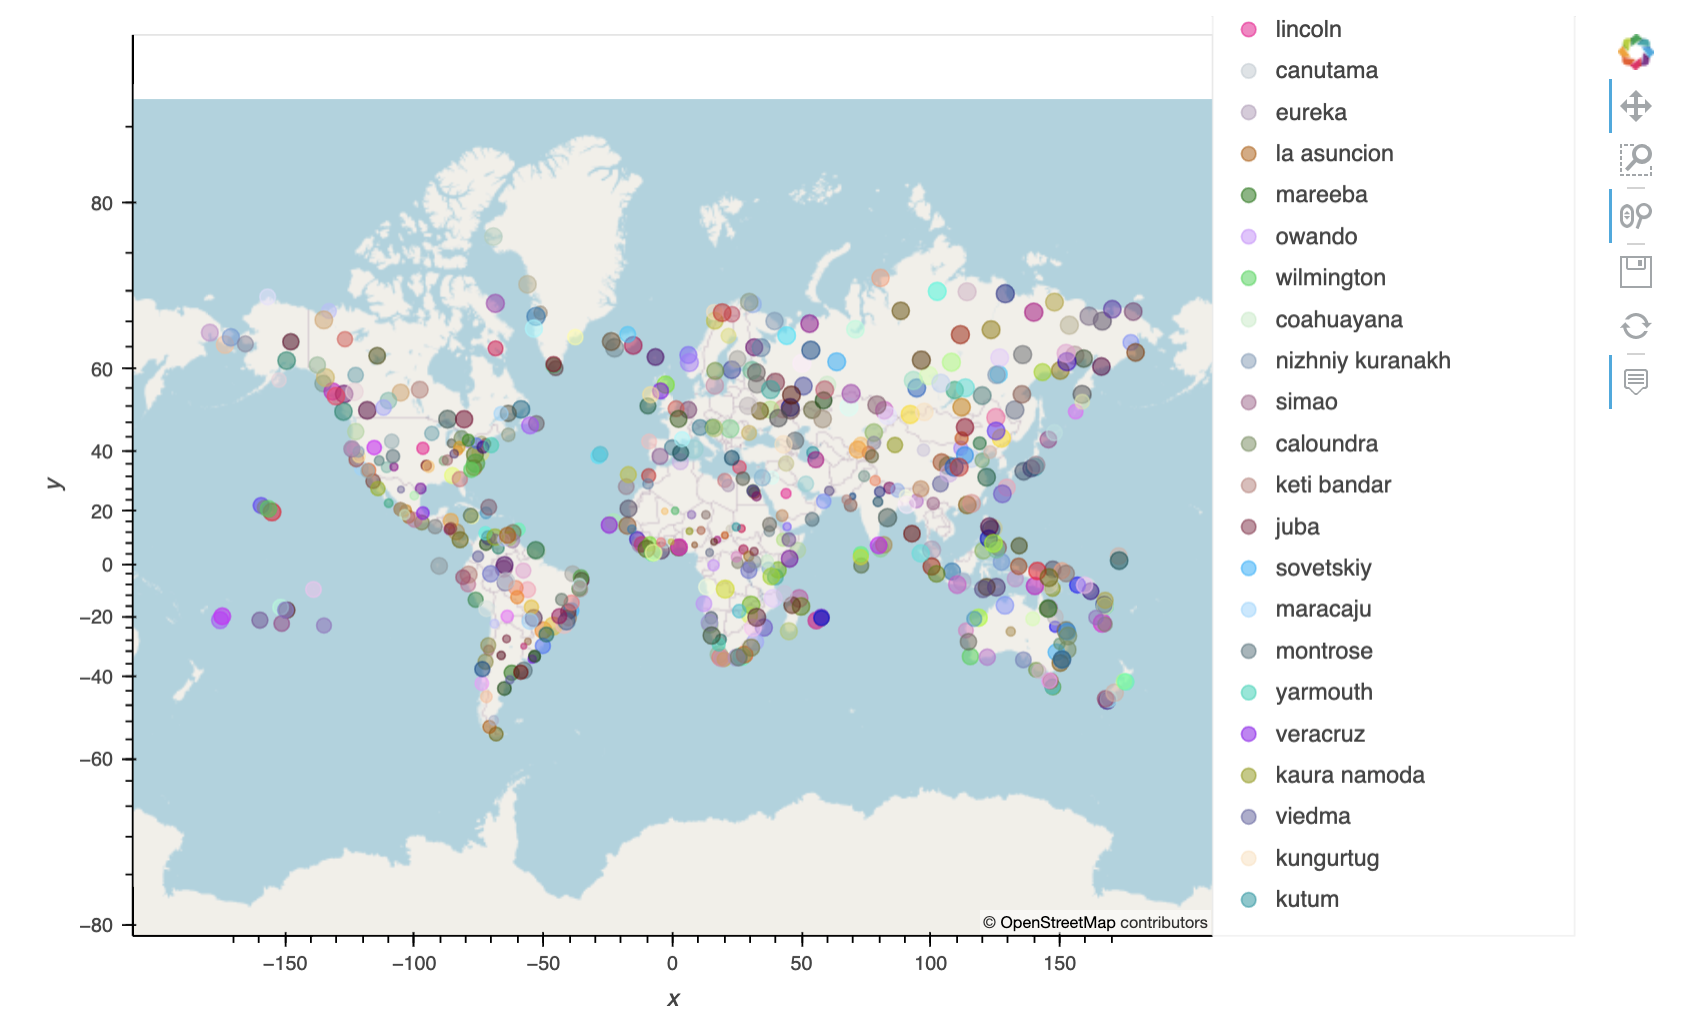

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [7]:
# Narrow down cities that fit criteria and drop any results with null values
vacation_df=city_data_df[
    (city_data_df["Max Temp"]>=20)&(city_data_df["Max Temp"]<=30)&(city_data_df["Wind Speed"]<5)&(city_data_df["Cloudiness"]>10)
].reset_index(drop=True)

# Drop any rows with null values
vacation_df.dropna()

# Display sample data
vacation_df

Unnamed: 0           City      Lat       Lng  Max Temp  Humidity  \
0            0        manggar  -2.8833  108.2667     24.88        86   
1            1         castro -24.7911  -50.0119     22.57        85   
2            4        rikitea -23.1203 -134.9692     25.75        68   
3           11  san cristobal   7.7669  -72.2250     26.10        50   
4           12    port alfred -33.5906   26.8910     22.88        95   
..         ...            ...      ...       ...       ...       ...   
95         553        mareeba -17.0000  145.4333     22.47        90   
96         554         owando  -0.4819   15.8999     27.31        38   
97         559      caloundra -26.8000  153.1333     23.27        94   
98         563       maracaju -21.6144  -55.1683     24.70        78   
99         566       veracruz  19.3333  -96.6667     22.33        47   

    Cloudiness  Wind Speed Country        Date  
0           99        1.80      ID  1676232355  
1           63        0.22      BR  1676232356  
2           47        1.32      PF  1676232358  
3           43        2.19      VE  1676232367  
4           93        1.34      ZA  1676232368  
..         ...         ...     ...         ...  
95         100        0.98      AU  1676232958  
96         100        1.78      CG  1676232960  
97          11        3.31      AU  1676232969  
98          96        2.36      BR  1676232974  
99          73        3.28      MX  1676232931  

[100 rows x 10 columns]

### Step 3: Create a new DataFrame called `hotel_df`.

In [8]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df=vacation_df[["City", "Country","Lat", "Lng","Humidity"]].copy()
# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"]=""
# Display sample data  
hotel_df

City Country      Lat       Lng  Humidity Hotel Name
0         manggar      ID  -2.8833  108.2667        86           
1          castro      BR -24.7911  -50.0119        85           
2         rikitea      PF -23.1203 -134.9692        68           
3   san cristobal      VE   7.7669  -72.2250        50           
4     port alfred      ZA -33.5906   26.8910        95           
..            ...     ...      ...       ...       ...        ...
95        mareeba      AU -17.0000  145.4333        90           
96         owando      CG  -0.4819   15.8999        38           
97      caloundra      AU -26.8000  153.1333        94           
98       maracaju      BR -21.6144  -55.1683        78           
99       veracruz      MX  19.3333  -96.6667        47           

[100 rows x 6 columns]

### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [6]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "categories":"accommodation.hotel",
    "apiKey":geoapify_key,
    "limit":20
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    
    # get latitude, longitude from the DataFrame
#     city=row["City"]
    latitude=row["Lat"]
    longitude=row["Lng"]
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make and API request using the params dictionaty
    response = requests.get(base_url,params=params)

#     Convert the API response to JSON format
    name_address = response.json()
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data

hotel_df


Starting hotel search
manggar - nearest hotel: No hotel found
castro - nearest hotel: Hotel Central Palace
rikitea - nearest hotel: Chez Bianca & Benoit
san cristobal - nearest hotel: Terra Sur
port alfred - nearest hotel: No hotel found
port blair - nearest hotel: Andaman Ocean Breeze
souillac - nearest hotel: Hotel SkylineInn
ende - nearest hotel: LCR Hotel
hambantota - nearest hotel: Oasis Aurweda Resort Hambathota
georgetown - nearest hotel: Page 63 hostel
bahia blanca - nearest hotel: Hotel Austral Bahía
cairns - nearest hotel: Cairns Queens Court Accommodation
caravelas - nearest hotel: Pousada dos Navegantes
mar del plata - nearest hotel: Nuevo Ostende
luganville - nearest hotel: Beachfront Resort
bredasdorp - nearest hotel: Victoria Hotel
ntungamo - nearest hotel: No hotel found
kruisfontein - nearest hotel: No hotel found
victoria - nearest hotel: 四季酒店 Four Seasons Hotel
kalang - nearest hotel: No hotel found
padang - nearest hotel: losmen Surya
bengkulu - nearest hotel: Dena 

City Country      Lat       Lng  Humidity  \
0         manggar      ID  -2.8833  108.2667        86   
1          castro      BR -24.7911  -50.0119        85   
2         rikitea      PF -23.1203 -134.9692        68   
3   san cristobal      VE   7.7669  -72.2250        50   
4     port alfred      ZA -33.5906   26.8910        95   
..            ...     ...      ...       ...       ...   
95        mareeba      AU -17.0000  145.4333        90   
96         owando      CG  -0.4819   15.8999        38   
97      caloundra      AU -26.8000  153.1333        94   
98       maracaju      BR -21.6144  -55.1683        78   
99       veracruz      MX  19.3333  -96.6667        47   

                  Hotel Name  
0             No hotel found  
1       Hotel Central Palace  
2       Chez Bianca & Benoit  
3                  Terra Sur  
4             No hotel found  
..                       ...  
95         The Gateway Hotel  
96         Hotel de l'Eglise  
97  Norfolks on moffat beach  
98           Hotel Cachoeira  
99            No hotel found  

[100 rows x 6 columns]

In [7]:
hotel_df=hotel_df.loc[hotel_df['Hotel Name'] != "No hotel found"]
hotel_df

City Country      Lat       Lng  Humidity  \
1          castro      BR -24.7911  -50.0119        85   
2         rikitea      PF -23.1203 -134.9692        68   
3   san cristobal      VE   7.7669  -72.2250        50   
5      port blair      IN  11.6667   92.7500        83   
6        souillac      MU -20.5167   57.5167        69   
..            ...     ...      ...       ...       ...   
92       kalmunai      LK   7.4167   81.8167        82   
95        mareeba      AU -17.0000  145.4333        90   
96         owando      CG  -0.4819   15.8999        38   
97      caloundra      AU -26.8000  153.1333        94   
98       maracaju      BR -21.6144  -55.1683        78   

                  Hotel Name  
1       Hotel Central Palace  
2       Chez Bianca & Benoit  
3                  Terra Sur  
5       Andaman Ocean Breeze  
6           Hotel SkylineInn  
..                       ...  
92             Saji new food  
95         The Gateway Hotel  
96         Hotel de l'Eglise  
97  Norfolks on moffat beach  
98           Hotel Cachoeira  

[72 rows x 6 columns]

### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [8]:
# %%capture --no-display

# Configure the map plot
hotel_plot = hotel_df.hvplot.points(
  "Lng",
  "Lat",
  geo = True,
  size = "Humidity",
  scale = 1,
  color = "City",
  alpha = 0.5,
  tiles = "OSM",
  frame_width = 700,
  frame_height = 500,
  hover_cols= ['Hotel Name', 'Country']
)
# Display the map
hotel_plot


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (City,Humidity,Hotel Name,Country)

In [9]:
#Screenshot just for reference when using github

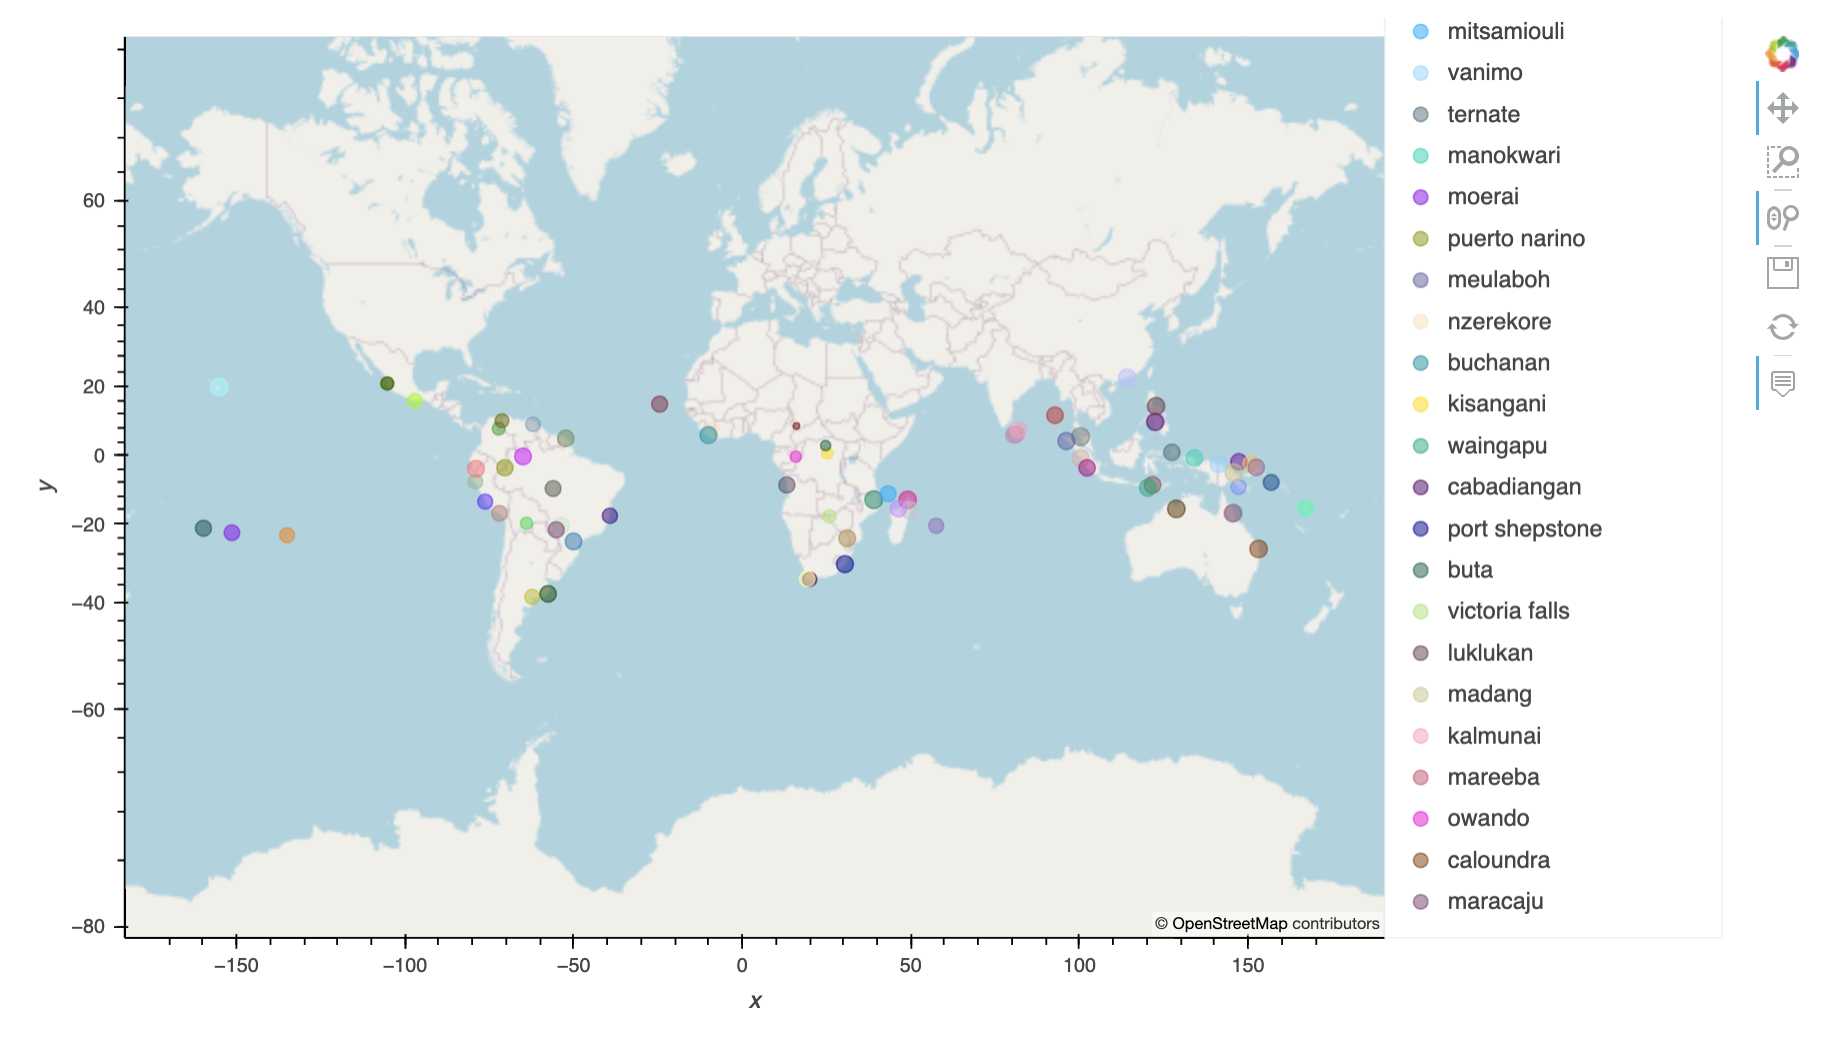